# Simple Template-Based Approach

In [13]:
import random
import pandas as pd
import numpy as np
import csv
import spacy
sp = spacy.load('en_core_web_sm')

import re
import nltk
from nltk.tokenize import word_tokenize
import re
nltk.download('tagsets')

from nltk.data import load
from nltk.corpus import conll2000
from nltk.chunk import regexp
import pickle

[nltk_data] Downloading package tagsets to /Users/renny/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


# 0. Parameters

In [2]:
# during pos tagging, to exclude the following pos tag type
remove_tagset = ['$','.',',',':','(',')','"','`','``',"'","''"]

In [3]:
#Retrieve movies genre
movies = pd.read_csv('data/ml-20m/movies.csv')

genres = list(movies['genres'])

all_genres = []
for item in genres:
    all_genres = all_genres + item.split('|')
            
all_genres = list(set(all_genres))
all_genres = [x.lower() for x in all_genres if x!='(no genres listed)']

for item in all_genres:
    if '-' in item:
        all_genres.append(item.replace('-',' '))
        all_genres.append(item.replace('-',''))

Build dictionary to capture all possible pos tags, from default pos tags in NLTK and also pos tags type from chunking
- pos_nltk_dictionary_all = dictionary containing all of possible nltk tags (JJ, JJR, VBG, VBD etc) grouped by key = group of pos (adjective, nouns, etc )
- pos_nltk_dictionary_reverse = reverse of the above dictionary with group of pos as key (adjective, noun, verb, etc) and list of possible nltk-tags and chunk tags (AP, adjective, VP, vers, noun, NP etc.)

In [4]:
adjective_phrase =['AP','AP_end_VBG'] 
verb_phrase = ['VP']
noun_phrase = ['NP','NP_VB_start','NP_end_VBG']
preposition_phrase =['PP'] 
Unknown =['multiwords']

# Load all possible pos tags from NLTK
tagdict = load('help/tagsets/upenn_tagset.pickle')

pos_nltk_dictionary_all = {}
for key in tagdict:
    item = tagdict[key][0].split(',')[0].split()[0]
    if re.search('[a-zA-Z]', key)!=None:
        if item in pos_nltk_dictionary_all:
            pos_nltk_dictionary_all[item].append(key)

        else:
            pos_nltk_dictionary_all[item] = [key]
    else:
        if "other" in pos_nltk_dictionary_all:
            pos_nltk_dictionary_all["other"].append(key)
        else:
            pos_nltk_dictionary_all["other"] = [key]

pos_nltk_dictionary_all['adjective']= pos_nltk_dictionary_all['adjective'] + adjective_phrase
pos_nltk_dictionary_all['verb'] = pos_nltk_dictionary_all['verb'] + verb_phrase
pos_nltk_dictionary_all['noun'] = pos_nltk_dictionary_all['noun'] + noun_phrase
pos_nltk_dictionary_all['unknown'] = Unknown
pos_nltk_dictionary_all['preposition'] = pos_nltk_dictionary_all['preposition'] + preposition_phrase

pos_nltk_dictionary_reverse = dict((v, k) for k in pos_nltk_dictionary_all for v in pos_nltk_dictionary_all[k])

# 1. Functions

In [5]:
class ConsecutiveNPChunkTagger(nltk.TaggerI):

    def __init__(self, train_sents):
        train_set = []
        for tagged_sent in train_sents:
            untagged_sent = nltk.tag.untag(tagged_sent)
            history = []
            for i, (word, tag) in enumerate(tagged_sent):
                featureset = npchunk_features(untagged_sent, i, history)
                train_set.append( (featureset, tag) )
                history.append(tag)
        #self.classifier = nltk.MaxentClassifier.train(
        #    train_set, algorithm='megam', trace=0)
        self.classifier = nltk.NaiveBayesClassifier.train(train_set)

    def tag(self, sentence):
        history = []
        for i, word in enumerate(sentence):
            featureset = npchunk_features(sentence, i, history)
            tag = self.classifier.classify(featureset)
            history.append(tag)
        return zip(sentence, history)

class ConsecutiveNPChunker(nltk.ChunkParserI):
    def __init__(self, train_sents):
        tagged_sents = [[((w,t),c) for (w,t,c) in
                         nltk.chunk.tree2conlltags(sent)]
                        for sent in train_sents]
        self.tagger = ConsecutiveNPChunkTagger(tagged_sents)

    def parse(self, sentence):
        tagged_sents = self.tagger.tag(sentence)
        conlltags = [(w,t,c) for ((w,t),c) in tagged_sents]
        return nltk.chunk.conlltags2tree(conlltags)
    
def npchunk_features(sentence, i, history):
    word, pos = sentence[i]
    if i == 0:
        prevword, prevpos = "<START>", "<START>"
    else:
        prevword, prevpos = sentence[i-1]
    if i == len(sentence)-1:
        nextword, nextpos = "<END>", "<END>"
    else:
        nextword, nextpos = sentence[i+1]
    return {"pos": pos,
            "word": word,
            "prevpos": prevpos,
            "nextpos": nextpos, 
            "prevpos+pos": "%s+%s" % (prevpos, pos),  
            "pos+nextpos": "%s+%s" % (pos, nextpos),
            "tags-since-dt": tags_since_dt(sentence, i)} 

def tags_since_dt(sentence, i):
    tags = set()
    for word, pos in sentence[:i]:
        if pos == 'DT':
            tags = set()
        else:
            tags.add(pos)
    return '+'.join(sorted(tags))

In [6]:
# Detect entities from tags, and try to filter out PERSON, ORG
def check_entities(text):
    sen = sp(text)
    entities = []
    entities_type = []
    for entity in sen.ents:
        entities.append(entity.text)
        entities_type.append(entity.label_)
    
    return entities, entities_type

def get_pos_tag(tag,chunker):
    tag = decontracted(tag)
  
    tag_token = word_tokenize(tag)
    tag_token = nltk.pos_tag(tag_token)
    tag_token = [x for x in tag_token if (x[1] not in remove_tagset) and (x[1]!='POS')] ## to remove 's , and symbols 
    print(tag)
    print(tag_token)
    
    
    #put the tag into sentence 'it is a [†ag] movies', so that the tagging can be more precise as it can see the context from the words surrounding it
    tag2 = "It is a {} film".format(tag)
    tag_token2 = word_tokenize(tag2)
    tags = nltk.pos_tag(tag_token2)
    tags = [x for x in tags if (x[1] not in remove_tagset) and (x[1]!='POS')]
    tagged_tags = tags[3:-1]


    if len(tagged_tags) == 1:
        #since the pos tagging only can recognize the form of word in the context from phrase or sentence
        #tag_token.append('movies')
        #Return only the pos_tag for the original word
#        if tag_token[0][1].startswith ('NN'): # If the single word is Noun then return noun
#            return tag_token[0][1],'-','-','-'
        #elif tagged_tags[0][0] in adjective_exceptions:
         #   return "JJ"
#        else:
        return (tagged_tags[0][1]),'-','-','-'
    else:
        #phrase_type,start_pos,end_pos,end_with_movie = chunk_multiwords(tagged_tags,chunker)
        phrase_type,start_pos,end_pos,end_with_movie = chunk_multiwords(tag_token,chunker)
        return phrase_type,start_pos,end_pos,end_with_movie


def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    return phrase
        
    
def chunk_multiwords(tagged_sent,chunker):
    ## the pos tagging can recognize 1950 and 1950s as cardinal but not 1950's, and 1950s movie & and 1950 movie as NP but not 1950's movie,
    ## therefore, removing the possessive ending 's before chunking
    #tagged = [x for x in tagged if (x[1] not in remove_tagset) and (x[1]!='POS')]
    len_tagged_sent = len(tagged_sent)
    
    start_pos = tagged_sent[0][1]
    end_pos = tagged_sent[len_tagged_sent-1][1]
    last_word = tagged_sent[len_tagged_sent-1][0]
    end_with_movie = 'movie' in last_word  or 'film' in last_word

    #chunk Noun Phrase, Verb Phrase, Preposition Phrase first
    chunk_tree = chunker.parse(tagged_sent)
    
    if (len(chunk_tree)==1):
        return chunk_tree[0].label(),start_pos,end_pos,end_with_movie
        
    else:
        #grammar = r"""
        #    AP: {<RB|PRP\$>*<JJ>+}   # chunk determiner/possessive, adjectives and noun
        #    AP_end_VBG: {<RB|AP><VBG|VBD>} # adjective phrase with adjective ending from verb-ing
        #"""

        grammar = r"""
            NP: {<DT|RB|CD|PRP\$>*<JJ.*>*<RB>?<NN.*>+} # noun phrase
            NP_VB_start: {<VB.*><NP.*>}   # noun phrase
            NP_end_VBG: {<NP|VB.*><VBG><RB.*>?} #noun phrase
            PP: {<IN><NP>}               # prepositional phrase
            AP: {<RB|PRP\$>*<JJ>+}   # chunk determiner/possessive, adjectives and noun
            AP_end_VBG: {<RB|AP><VBG>} # adjective phrase with adjective ending from verb-ing
            VP: {<MD>?<VB.*><RB>?<VB.*>?<NP|PP>?}     # verb phrase
        """
        #chunker = regexp.RegexpParser(grammar, loop=2)
        chunker_2 =  nltk.RegexpParser(grammar, loop =1)
        chunked_sent = chunker_2.parse(tagged_sent)
        #if it recognize the phrase as one of the phrase type it return the phrase type (NP, AP, PP, VP)
        if len(chunked_sent)==1:
            return chunked_sent[0].label(),start_pos,end_pos,end_with_movie
        else:
            return "multiwords",start_pos,end_pos,end_with_movie
 

POS Tags - list

- CC	coordinating conjunction
- CD	cardinal digit
- DT	determiner
- EX	existential there (like: "there is" ... think of it like "there exists")
- FW	foreign word
- IN	preposition/subordinating conjunction
- JJ	adjective	'big'
- JJR	adjective, comparative	'bigger'
- JJS	adjective, superlative	'biggest'
- LS	list marker	1)
- MD	modal	could, will
- NN	noun, singular 'desk'
- NNS	noun plural	'desks'
- NNP	proper noun, singular	'Harrison'
- NNPS	proper noun, plural	'Americans'
- PDT	predeterminer	'all the kids'
- POS	possessive ending	parent's
- PRP\$	personal pronoun	I, he, she
- PRP	possessive pronoun	my, his, hers
- RB	adverb	very, silently,
- RBR	adverb, comparative	better
- RBS	adverb, superlative	best
- RP	particle	give up
- TO	to	go 'to' the store.
- UH	interjection	errrrrrrrm
- VB	verb, base form	take
- VBD	verb, past tense	took
- VBG	verb, gerund/present participle	taking
- VBN	verb, past participle	taken
- VBP	verb, sing. present, non-3d	take
- VBZ	verb, 3rd person sing. present	takes
- WDT	wh-determiner	which
- WP	wh-pronoun	who, what
- WP$	possessive wh-pronoun	whose
- WRB	wh-abverb	where, when

# 2. Tags Filtering & Preprocessing

### Get list of tags which are used by at least 5 users and at least in 2 movies

In [2]:
tags = pd.read_csv('data/ml-20m/tags.csv')
tags['tag'] = [str(x).lower() for x in tags['tag']]
tags_subset = tags[['userId','movieId','tag']]

In [8]:
## Checking for duplicates
userId_tag = tags_subset[['userId','tag']].drop_duplicates()
movieId_tag = tags_subset[['movieId','tag']].drop_duplicates()

In [9]:
#Tag used by m >= 5 users
tag_by_users = pd.DataFrame(userId_tag['tag'].value_counts().sort_values(ascending = False)).reset_index()
tag_by_users.columns = ['tag','count_tag']
list_tag_by_users = list(tag_by_users[tag_by_users['count_tag']>=5]['tag'].values)
len(list_tag_by_users)

6018

In [10]:
#Tag used in n >= 2 number of movies
movieId_tag['tag'].value_counts().describe()

tag_by_movies = pd.DataFrame(movieId_tag['tag'].value_counts().sort_values(ascending = False)).reset_index()
tag_by_movies.columns = ['tag','count_tag']
list_tag_by_movies=list(tag_by_movies[tag_by_movies['count_tag']>=2]['tag'].values)
len(list_tag_by_movies)

14029

In [11]:
# Get intersection to filter out tags which has been used by at least 5 users and used on at least 2 items
#list_of_tags =  list(np.intersect1d(list_tag_by_movies, list_tag_by_users))
list_of_tags = sorted(set(list_tag_by_movies).intersection(list_tag_by_users))
len(list_of_tags)


5709

### Simple cleaning from inappropriate content

In [12]:
inappropriate = ['boob','\xa0','nude','nudity','sexuality','damn','crap','shit','topless','sex','tits','fuck','erotic','fucking','pervert','perverted','rape','porn','cleavage']
cleaned_list_of_tags = []

for tag in list_of_tags:   
    in_tag = 0
    for x in inappropriate:
        if x in tag:
            in_tag+=1
    if (in_tag==0) & (len(tag)>1):
        cleaned_list_of_tags.append(tag)

len(cleaned_list_of_tags)

5612

### POS tagging and entities recognition on tags

In [13]:
test_sents = conll2000.chunked_sents('test.txt')#, chunk_types=['NP'])
train_sents = conll2000.chunked_sents('train.txt')#, chunk_types=['NP'])
chunker = ConsecutiveNPChunker(train_sents)

In [22]:
# speech tagging 

## read actors and directors list from imdb
f = open('data/1000_actors_actress.txt', 'r')
actors = f.readlines()
f.close()
actors =[x.strip().lower() for x in actors] 

f= open('data/directors.txt','r')
directors = f.readlines()
f.close()
directors = [x.strip().lower() for x in directors]


mapped_tags_to_group = {}
mapped_tags_to_group_nonperson = {}
tagged_tags_dictionary = {}

for item in cleaned_list_of_tags:
    postag,start_pos,end_pos,end_with_movie = get_pos_tag(item,chunker)
    group = pos_nltk_dictionary_reverse[postag]
    
    ends_with_genre = False
    
    for genre in all_genres:
        if item.endswith(genre):
            ends_with_genre = True
            break
    
    #Get Entity
    tag_ent, tag_ent_type = check_entities(item)
    if tag_ent_type!=[]:
        if ((len(tag_ent_type)==1)):
            if (tag_ent_type[0] == 'GPE') & (tag_ent[0]!= item):
                if tag_ent == item:
                    entity = 'No Entity'
            else:    
                entity = tag_ent_type[0]
        else:
            entity = 'Multi Entities'
    else:
        entity = 'No Entity'
        
    #get person type
    x = item.strip().lower()
    if x in actors:
        person_type='actor'
        entity = 'PERSON'
        
    elif x in directors:
        person_type='director'
        entity = 'PERSON'
    
    else:
        person_type= '-'
    
    # If entity is person,then change the postag to 'NP' - Noun phrase
    if entity == 'PERSON':
        postag = 'NP'
        group = 'noun'
        
    ## Map all tags to group of pos-tags (adjective, noun, verb, etc)
    if group in mapped_tags_to_group:
        mapped_tags_to_group[group].append(item)
    else:
        mapped_tags_to_group[group] = [item]
        
    ## Map all tags to group of pos-tags (adjective, noun, verb, etc) exclude tags with entity type person
    if entity!='PERSON':
        if group in mapped_tags_to_group_nonperson:
            mapped_tags_to_group_nonperson[group].append(item)
        else:
            mapped_tags_to_group_nonperson[group] = [item]
    
    tagged_tags_dictionary[item]={ 'POS_Tags': postag,
                                   'POS_Tags_Group':group,
                                   'Entity': entity,
                                   'Person_Type': person_type,
                                   'Start_POS' : start_pos,
                                   'End_POS' : end_pos,
                                   'End_with_movie' : end_with_movie,
                                   'genre' : ends_with_genre
                                    }
        
tags_dataframe = pd.DataFrame(tagged_tags_dictionary).T.reset_index().rename(columns={'index': 'Tags'})   



"found footage"
[('found', 'VBD'), ('footage', 'NN')]
*good* musicals
[('*good*', 'NN'), ('musicals', 'NNS')]
007
[('007', 'CD')]
007 (series)
[('007', 'CD'), ('series', 'NN')]
100 essential female performances
[('100', 'CD'), ('essential', 'JJ'), ('female', 'NN'), ('performances', 'NNS')]
100 greatest movies
[('100', 'CD'), ('greatest', 'JJS'), ('movies', 'NNS')]
16mm
[('16mm', 'CD')]
16th century
[('16th', 'JJ'), ('century', 'NN')]
17th century
[('17th', 'JJ'), ('century', 'NN')]
1800s
[('1800s', 'CD')]
18th century
[('18th', 'JJ'), ('century', 'NN')]
1900s
[('1900s', 'CD')]
1910s
[('1910s', 'CD')]
1920s
[('1920s', 'CD')]
1930s
[('1930s', 'CD')]
1940's
[('1940', 'CD')]
1940s
[('1940s', 'NNS')]
1950s
[('1950s', 'NNS')]
1950s housewives
[('1950s', 'CD'), ('housewives', 'NNS')]
1960s
[('1960s', 'NNS')]
1970's
[('1970', 'CD')]
1970s
[('1970s', 'NNS')]
1980's
[('1980', 'CD')]
1980s
[('1980s', 'CD')]
1984
[('1984', 'CD')]
1990s
[('1990s', 'CD')]
19th century
[('19th', 'JJ'), ('century', 'N

In [23]:
#save the tags information with attributes to excel for easy analysis
tags_dataframe.to_excel('tags_dataframe_modified_19_03_20(all_single_tag_with_sent_film).xlsx')

#save the tagged_tags_dictionary to pickle file
with open('output/tagged_tags_dictionary_withsents_film.pkl', 'wb') as f:
    pickle.dump(tagged_tags_dictionary, f)


In [34]:
with open('output/mapped_tags_to_group_film','wb') as f:
    pickle.dump(mapped_tags_to_group,f)
with open('output/mapped_tags_to_group_nonperson_film','wb') as f:
    pickle.dump(mapped_tags_to_group_nonperson,f)

### Analyse the proportion of POS tags

In [24]:
## Viewing the proportion of POS tag in the tags list
percentage_pos_tags = tags_dataframe['POS_Tags'].value_counts()/len(tags_dataframe)

In [25]:
percentage_pos_tags.index

Index(['NP', 'NN', 'JJ', 'multiwords', 'NNS', 'NP_VB_start', 'VP', 'AP',
       'NP_end_VBG', 'CD', 'PP', 'RB', 'AP_end_VBG', 'VBG', 'VBN'],
      dtype='object')

In [26]:
# Get all of pos-tags from the tags
unique_tags_group = {}
for item in percentage_pos_tags.index:
    if pos_nltk_dictionary_reverse[item] in unique_tags_group:
        unique_tags_group[pos_nltk_dictionary_reverse[item]].append(item)
    else:
        unique_tags_group[pos_nltk_dictionary_reverse[item]] = [item]
unique_tags_group

{'noun': ['NP', 'NN', 'NNS', 'NP_VB_start', 'NP_end_VBG'],
 'adjective': ['JJ', 'AP', 'AP_end_VBG'],
 'unknown': ['multiwords'],
 'verb': ['VP', 'VBG', 'VBN'],
 'numeral': ['CD'],
 'preposition': ['PP'],
 'adverb': ['RB']}

In [27]:
summary_percentage_all = {}
for key in unique_tags_group:
    summary_percentage_all[key] = str(round(sum([percentage_pos_tags[x] for x in unique_tags_group[key]])*100,2)) + '%'
summary_percentage_all

{'noun': '80.4%',
 'adjective': '12.06%',
 'unknown': '5.83%',
 'verb': '0.96%',
 'numeral': '0.48%',
 'preposition': '0.14%',
 'adverb': '0.12%'}

In [423]:
## Proportion of POS tag without 'PERSON' entity
percentage_no_person = tags_dataframe[(tags_dataframe['Entity']!='PERSON') ]['POS_Tags'].value_counts()/len(tags_dataframe[(tags_dataframe['Entity']!='PERSON')])

summary_percentage_no_person = {}

for key in unique_tags_group:
    summary_percentage_no_person[key] = str(round(sum([percentage_no_person[x] for x in unique_tags_group[key]])*100,2)) + '%'

summary_percentage_no_person 

{'noun': '73.58%',
 'adjective': '16.26%',
 'unknown': '7.85%',
 'verb': '1.3%',
 'numeral': '0.65%',
 'preposition': '0.19%',
 'adverb': '0.17%'}

In [17]:
test_text = "I love Korean drama"
tag_token = word_tokenize(test_text)
tag_token = nltk.pos_tag(tag_token)

In [18]:
tag_token


[('I', 'PRP'), ('love', 'VBP'), ('Korean', 'JJ'), ('drama', 'NN')]

In [23]:
pd.DataFrame(nltk.help.upenn_tagset())

$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

""


In [ ]:
                 ("her", "PP$"), ("long", "JJ"), ("golden", "JJ"), ("hair", "NN")]

grammar = r"""
            NP: {<DT|RB|CD|PRP\$>*<JJ.*>*<RB>?<NN.*>+} # noun phrase
            NP_VB_start: {<VB.*><NP.*>}   # noun phrase
            NP_end_VBG: {<NP|VB.*><VBG><RB.*>?} #noun phrase
            PP: {<IN><NP>}               # prepositional phrase
            AP: {<RB|PRP\$>*<JJ>+}   # chunk determiner/possessive, adjectives and noun
            AP_end_VBG: {<RB|AP><VBG>} # adjective phrase with adjective ending from verb-ing
            VP: {<MD>?<VB.*><RB>?<VB.*>?<NP|PP>?}     # verb phrase
        """

In [45]:
#Play around - to be deleted
tag= "visually stunning"

tag_token = word_tokenize(tag) 
tag_token = nltk.pos_tag(tag_token)

#Set regular expressions
grammar = r"""
            AP: {<RB|PRP\$>*<JJ>+}   # To chunk Adjective phrase such as "very beautiful"
            AP: {<RB|AP><VBG>}       # To chunk adjective phrase such as "visually stunning"
        """
chunker = nltk.RegexpParser(grammar,loop=1)
print(chunker.parse(tag_token))

(S (AP visually/RB stunning/VBG))


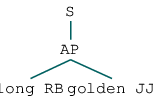

In [43]:
chunked_sent